# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

## 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

from unityagents import UnityEnvironment
import numpy as np
import random
import copy
from collections import namedtuple, deque
import os
import time
import sys

import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='./Reacher_Linux/Reacher.x86_64',
                       no_graphics = True)
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
# size of each state
states = env_info.vector_observations[0]
state_size = states.shape[0]
print("state_size = ", state_size)

Number of agents: 20
state_size =  33


The displayed result shows that we take option 2 for the solution of the project, and there are 20 double-jointed arms to be trained.

## 2. DDPG Algorithm
### 2.1 The DDPG

The deep deterministic policy gradient (DDPG) method [1] is a model free reinforcement learning algorithm, and it is an extension of the deterministic policy gradient (DPG) method [2]. The difference between the two method is that, DPG considers the deterministic policies which considers that
$$
a = \mu_\theta(s)
$$
where a is the action, $\mu$ is the policy, $\theta$ is the parameters and s is the state.

The DDPG method adopts the actor-critic approach with Deep Q Network[3] to form a model-free, off-policy reinforcement learning algorithm for the learning of optimal policies in high-dimensional and continuous action spaces problems, such as autonomous driving and robotics, etc. For the example problems, their actuators receives continuous command, such as throttle and joint torques. The DQN method can only handle discrete action space, for that reason, its application is limited.

### 2.2 The actor-critic

The DDPG uses stochastic policy for the agent, i.e.
$$
\pi_{\theta}(a|s)=\mathbb{P}[a|s,\theta]
$$
where $\theta$ is the parameter vector, $\pi$ is the policy.

For this problem, the stochastic actor-critic method is applied. the actor is applied to find the optimal $\theta^*$ in order to approach the optimal policy $\pi^*$, that's to say, $ \pi_{\theta}(a|s)\rightarrow\pi^*_{\theta}(a|s)$. For policy gradient method, the state-value function has to be estimated as well. In this approach, the critic is applied to adjust the parameter vector to approximate the sate-value function $Q^{\pi}(s,a)$. Then, an approach similar to DQN method is applied for both actor-critic networks.

For the process of training actor network, the training data are randomly picked from the **Experience Replay Buffer**. The predicted action $a_p\{t\}$ is generated via **Local** actor network fed by current state $s_t$. Then, an approximated action-value function $Q^\omega(s_t,a_{p\{t\}})$. An unary minus of the approximated action-value function is directly used as the loss function for the update of the **Local** actor network. 

The update of critic network is even more complex. First of all, since we prefer to get the **Expected** action-value function, we use the state of the next time step $s_{t+1}$. An next time step action is guessed via the **Target** network of the actor. And The expected value function is generated via **Target** network of the critic, and the action value function is generated via **Local** network of critic. Then, the Bellman equation is calculated with the value function, and the mean-square-error loss function is applied for the update of **Local** network of the critic.

Bear in mind that, for both actor and critic network, the Target network are slowly converged to the Local network through **soft update**.

The **ReplayBuffer** class is a container which stores the past experiences. In the learn procedure, the past experiences are stochastically chosen and are fed into the two Q-networks. One Q-network is fixed as Q-target, it is denoted by$\theta^-$. This Q-network is 'detached' in the training process, in order to achieve better stability. As a consequence, the change in weights can be expressed as 
$$
\Delta \theta = \alpha \left[ (R + \gamma \max_{a} \hat{Q}(s,a, \theta^-) -\hat{Q}(s,a,\theta))\nabla_{\theta}\hat{Q}(s,a,\theta) \right]
$$
DDPG is an off-policy algorithm, as a matter of fact, the exploration procedure can be conducted independently. This procedure is kind of policy gradient method. An stochastic actor is determined by the current policy, and noise generated by the **Uhlenbeck & Ornstein** method is added to it for searching the gradient direction, until it approaches the optimal policy. Thus the actor policy can be expressed as
$$
\pi'(s_t)=\pi(s_t|\theta_t^\pi)+\mathcal{N}
$$
where $\mathcal{N}$ is the noise for searching 'best' actions.

In [4]:
class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """

        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        
        #Specify a decay rate for the stocastic reach policy
        self.epsilon = 1.;
        self.epsilon_decay_rate = 0.999
        self.epsilon_min = 0.8;

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR), weight_decay=WEIGHT_DECAY)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        #Copy the weights from local to target networks
        self.soft_update(self.critic_local, self.critic_target, 1)
        self.soft_update(self.actor_local, self.actor_target, 1)
        
        # Noise for action exporation
        self.noise = OUNoise((NUM_AGENTS, action_size), random_seed)

        # experience replay buffer
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    
    def epsilon_decay(self):
        self.epsilon = max(self.epsilon*self.epsilon_decay_rate, self.epsilon_min)
    
    def step(self, state, action, reward, next_state, done, step):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        
        #Put SARS into the replay buffer
        self.memory.add(state, action, reward, next_state, done)

        # perform learning process when enough experiences are stored
        if len(self.memory) > BATCH_SIZE and (step % TRAIN_EVERY) == 0 :
            for _ in range(NUM_TRAINS) :
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""

        state = torch.from_numpy(state).float().to(device)

        self.actor_local.eval()
        
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
            
        self.actor_local.train()
        #the noise is added with an decay
        if add_noise:
            action += self.epsilon * self.noise.sample()
        
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
                
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models        
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next).detach()
        
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        Q_expected = self.critic_local(states, actions)
        
        # Compute critic loss
        critic_loss = F.mse_loss(Q_expected, Q_targets)

        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()

        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()

        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, shape, seed, mu=0., theta=0.15, sigma=0.08):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(shape)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * (np.random.rand(*x.shape)-0.5)
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### 2.2 The model

In this project, the Q-net is constructed by **three fully connected layers**. The architecture is the same as the network described in the paper [1]. But the units are reduced to reduce the computational time, since the problem is simpler.  In this case, the hidden layers are with 128 and 256 units respectively. For the input layer, the number of input node is the same as the number of states of the agent.  Finally, for the output layer, the number of output layer is the same as the action size of the agent. For the input layer and the out put layer, the output value is activated by the **Rectified Linear Unit** (ReLU) function. Since this is a continuous control problem, we have to use **tanh** function for the output of final layer. The network for the critic has the same structure as the actor network. however, the critic approximates the action-value function, its input should be states and action, consequently, the number of node for the input layer is the number of states plus the number of actions. 

In [5]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=256):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=128, fc2_units=256):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

## 3. Learning Process

### 3.1 Hyper-parameters

The hyper parameters for the learning process are generally utilized the parameters provided by  the paper [1]. However, some modifications are conducted for both convergence and stability. The WEIGHT_DECAY is set as 0. And I conduct one training process in very 25 time steps. In my  hyper-parameters tuning experience, TRAIN_EVERY influence the convergence significantly. At one training step, I set NUM_TRAINS as 5 to conduct 5 trains at a time. Other difference  is that I increase the minibatch size to 128 to allow more past experiences to be used for one training. Another improvement is that, I reduce the exploration noise a decay rate (say 0.999) to achieve better stability.

In [6]:
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 256        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0.     # L2 weight decay
TRAIN_EVERY = 25        # how often to update the network
NUM_AGENTS = num_agents
NUM_TRAINS = 5

agent = Agent(state_size, action_size, random_seed=10)

### 3.2 The Learning Process

The agent choose an action corresponding to  the current state via the Local network of the actor. And the action is applied to the environment, generates the reward of the action and the state, and the transmission of the next state. Than, they are stored in the Experience Replay Buffer for the training process.

In [7]:
def ddpg(n_episodes = 500, max_t = 1000, display_rate = 10):
    scores_deque = deque(maxlen=100)
    scores = []
    print("Training Process Started! \n")
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations

        score = np.zeros(NUM_AGENTS)
        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            
            for i in range(20) :
                agent.step(states[i], actions[i], rewards[i], next_states[i], dones[i], t)
            
            states = next_states
            score += rewards
            if np.any(dones):                                 
                break
        
        agent.epsilon_decay()
        score = score.mean()
        scores.append(score)
        scores_deque.append(score)

        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, np.mean(scores_deque), score), end="")
        if i_episode % display_rate == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor' + str(i_episode) + '.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic' + str(i_episode) + '.pth')
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        
        if i_episode % display_rate == 0 and np.mean(scores_deque) >= 30:
            break
    
    torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
    torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
    
    print("Training Process Ended! \n")
    return scores
            
            
        
scores = ddpg()

Training Process Started! 

Episode 10	Average Score: 1.81	Score: 2.48
Episode 20	Average Score: 2.61	Score: 3.78
Episode 30	Average Score: 4.22	Score: 7.95
Episode 40	Average Score: 5.82	Score: 11.75
Episode 50	Average Score: 7.31	Score: 14.69
Episode 60	Average Score: 8.92	Score: 17.72
Episode 70	Average Score: 10.70	Score: 23.24
Episode 80	Average Score: 12.65	Score: 25.71
Episode 90	Average Score: 14.51	Score: 29.67
Episode 100	Average Score: 16.25	Score: 32.52
Episode 110	Average Score: 19.44	Score: 34.34
Episode 120	Average Score: 22.51	Score: 35.45
Episode 130	Average Score: 25.25	Score: 35.36
Episode 140	Average Score: 27.79	Score: 35.27
Episode 150	Average Score: 30.16	Score: 36.05
Training Process Ended! 



### 3.3 Experimental Result

The Figure shows the learning procedure. With the prescribed structure and hyper parameters, the networks converges to the 'optimal policy' nicely with little oscillations. And the agent reaches the target average score 30 in 150 episodes, which means the network structure and the hyper parameters defined find a good balance point between exploration and exploitation.

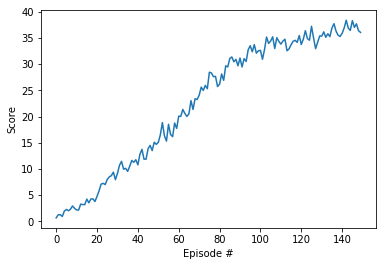

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

When finished, you can close the environment.

In [9]:
env.close()

[1] Lillicrap, T. Hunt, J. Pritzel, A. Heess, N. Erez, T. Tassa, Y. Silver, D. & Wierstra, D. (2016). Continuous Control with Reinforcement Learning, In Proceedings of ICLR. https://arxiv.org/abs/1509.02971

[2] Silver, D., Lever, G., Heess, N., Degris, T., Wierstra, D., & Riedmiller, M.A. (2014). Deterministic Policy Gradient Algorithms. ICML. https://dl.acm.org/doi/10.5555/3044805.3044850

[3] Watkins, C.J., Dayan, P. Technical Note: Q-Learning. Machine Learning 8, 279–292
(1992). https://doi.org/10.1023/A:102267672231

[4] Sutton R, Barto A, Reinforcement Learning: An Introduction, The MIT Press, 2018.

[5] https://github.com/FlyienSHaDOw/deep-reinforcement-learning.